In [6]:
using ModelingToolkit, Sophon, DomainSets, TaylorDiff
using Optimization, OptimizationOptimJL

@parameters t, x
@variables u(..)
Dt = Differential(t)
Dx = Differential(x)
Dxx = Differential(x)^2

r1 = 0.02
r2 = 1

eq = Dt(u(t, x)) - Dxx(r2*(u(t,x)^3 - u(t,x)) - r1 * Dxx(u(t,x))) ~ 0.0

bcs = [u(0, x) ~ cospi(x)-exp(-4*π*π*abs2(x)),
    u(t, -1.0) ~ u(t, 1.0),
    Dx(u(t, -1.0)) ~ Dx(u(t, 1.0))]

domains = [t ∈ Interval(0.0, 1.0),
    x ∈ Interval(-1.0, 1.0)]

@named pde_system = PDESystem(eq, bcs, domains, [t,x], [u(t,x)])

PDESystem
Equations: Equation[Differential(t)(u(t, x)) - Differential(x)(Differential(x)(u(t, x)^3 - 0.02Differential(x)(Differential(x)(u(t, x))) - u(t, x))) ~ 0.0]
Boundary Conditions: Equation[u(0, x) ~ cospi(x) - exp(-39.47841760435743abs2(x)), u(t, -1.0) ~ u(t, 1.0), Differential(x)(u(t, -1.0)) ~ Differential(x)(u(t, 1.0))]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0..1.0), Symbolics.VarDomainPairing(x, -1.0..1.0)]
Dependent Variables: Num[u(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [7]:
chain = FullyConnected(2, 1, tanh; hidden_dims=16, num_layers=5)
pinn = PINN(chain)
sampler = BetaRandomSampler(1000, (400, 100, 100))
strategy = NonAdaptiveTraining(1, (500,10,10))
prob = Sophon.discretize(pde_system, pinn, sampler, strategy)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = (weight = [0.5936875939369202 1.0201783180236816; -1.1745996475219727 0.8660504817962646; … ; 0.9426403641700745 -0.37895864248275757; 0.8876739144325256 -0.20341219007968903], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_2 = (weight = [0.49161460995674133 -0.1684776246547699 … -0.31622233986854553 -0.36320358514785767; 0.11886054277420044 0.222892627120018 … 0.3076624274253845 0.2836836278438568; … ; 0.23531287908554077 0.6312450766563416 … 0.21958331763744354 0.011488440446555614; -0.20617637038230896 0.500881016254425 … 0.10485231131315231 -0.285427987575531], bias = [0.0; 0.0; … ; 0.0; 0.0;;]), layer_3 = (weight = [-0.21837586164474487 0.019129276275634766 … 0.09540574997663498 0.30318841338157654; 0.412481427192688 0.6510142087936401 … -0.1287781298160553 -0.014194229617714882; … ; -0.5453404784202576 -0.2729429602622986 … 0.27946409583091736 0.19096972048282623; 0.4505859911441803 0.4191191494464874 … 0.07999

In [8]:
i = 0
function callback(p, l)
    global i
    i%100==0 && println("Loss: $l")
    i += 1
    return false
end

res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

Loss: 8084.678346217548


Loss: 7.050536344378762


Loss: 4.6723055602983985


Loss: 2.8030358036122256


Loss: 0.9488078781865003


Loss: 0.21991535843150012


Loss: 0.05249624748803473


Loss: 0.01955577399837068


Loss: 0.012094200281423275


Loss: 0.008179010309568432


Loss: 0.004996051359463105


u: ComponentVector{Float64}(layer_1 = (weight = [1.5311405544680454 1.0135589232801976; -5.81134936024479 0.9401486060275295; … ; 1.1397877757290094 -0.35339871998984845; 1.2155137190034007 -0.663249257203965], bias = [0.005892828691230737; -0.814058536705173; … ; 0.21778124355922143; 0.4088344842357877;;]), layer_2 = (weight = [0.10314554280018459 0.30051173159689054 … 0.09675651367196811 -0.8987072820153471; 0.7816607678738825 -0.054848673300616414 … 0.752434538256777 1.0366312281675305; … ; 0.8833364121419178 1.22826880819743 … 1.1670149549366917 -0.15118963262219143; 0.18852348776482222 0.16696005503941327 … -0.027349178595611336 0.12278783862597802], bias = [-1.0428008834545095; -0.24330465658964043; … ; -0.4730483625415751; 1.6446298203565504;;]), layer_3 = (weight = [-0.25413553930994753 -0.7919691144458361 … 1.0388277058396407 0.1722337845924391; 1.5603367020300003 1.0682274752264382 … 0.18789012141923048 1.1622021310557995; … ; 0.046133316280330086 -0.3539501733823766 … 1.2339

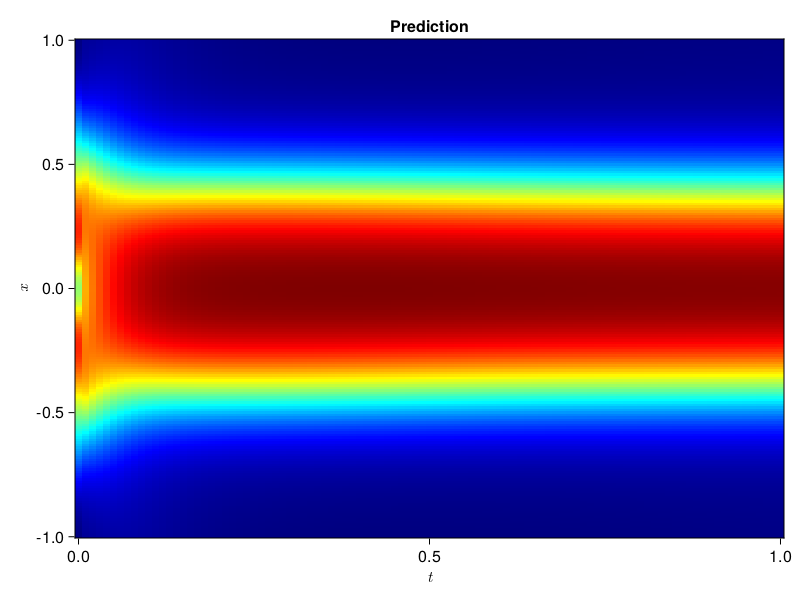

In [9]:
using CairoMakie, MakiePublication

phi = pinn.phi
ts, xs = [infimum(d.domain):0.01:supremum(d.domain) for d in pde_system.domain]
axis = (xlabel=L"t", ylabel=L"x", title="Prediction")
u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)

Loss: 31.103611160573998


Loss: 0.009533759083503682


Loss: 0.0011691451152862611


Loss: 0.0004495094142512088


Loss: 0.0001801464597835215


Loss: 8.90490891772528e-5


Loss: 5.026868187729677e-5


Loss: 3.551995490435045e-5


Loss: 2.5591399416965257e-5


Loss: 1.9120054964223738e-5


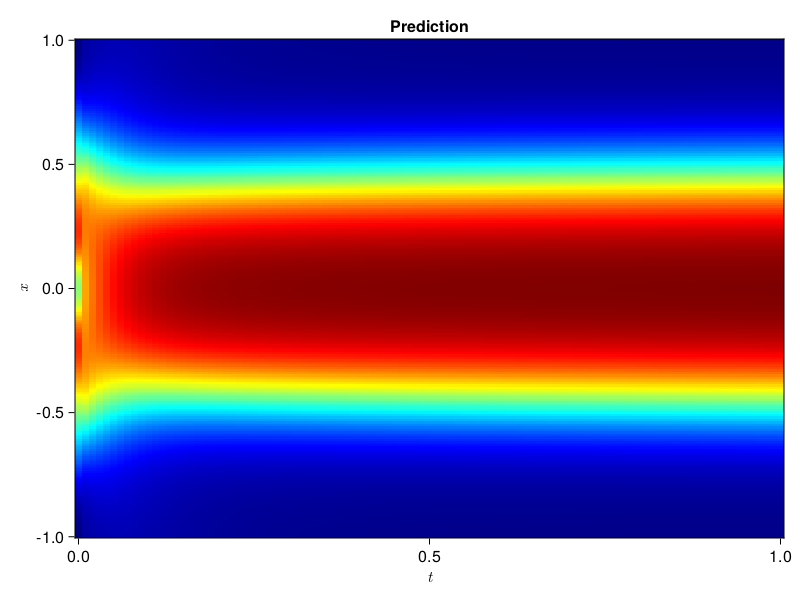

Loss: 1.3931006562199649e-5


Loss: 0.03389573080837952


Loss: 3.1604864484435294e-5


Loss: 1.221933924743308e-5


Loss: 7.897857578328879e-6


Loss: 5.6282312204990175e-6


Loss: 4.023089887820714e-6


Loss: 3.197984135600609e-6


Loss: 2.514013476214776e-6


Loss: 1.9089719752112356e-6


Loss: 1.4099736763341887e-6


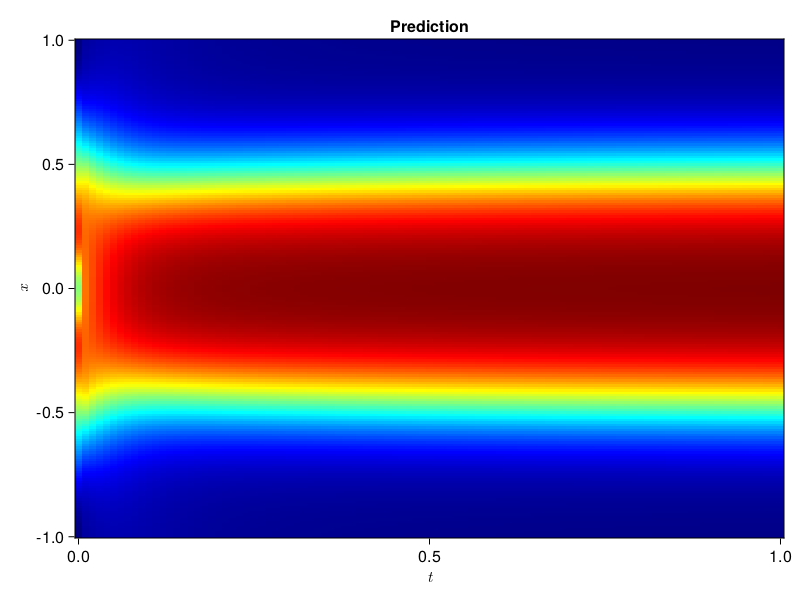

Loss: 1.1043590541826975e-6


Loss: 0.01576830534373496


Loss: 9.994981039586081e-6


Loss: 1.4776070052298116e-6


Loss: 1.0282262454370751e-6


Loss: 8.164225907053929e-7


Loss: 6.831795878391267e-7


Loss: 5.893628272203605e-7


Loss: 5.235649417895701e-7


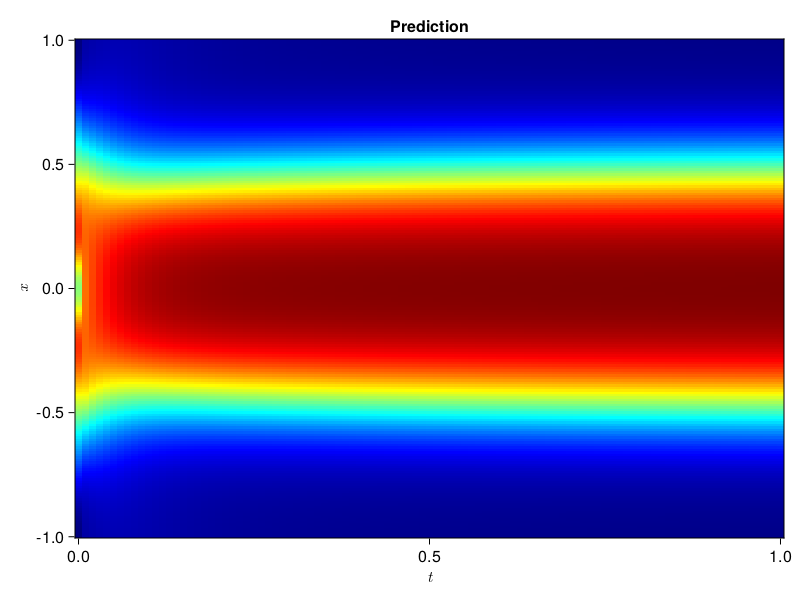

Loss: 4.5679560085500415e-7


In [10]:
for α in [0.6, 0.8, 1.0] 
    i = 0
    sampler = remake(sampler; α=α)
    data = Sophon.sample(pde_system, sampler)
    prob = remake(prob; p=data, u0=res.u)
    res = Optimization.solve(prob, BFGS(); maxiters=1000, callback=callback)

    u_pred = [sum(pinn.phi([t, x], res.u)) for t in ts, x in xs]
    fig, ax, hm = heatmap(ts, xs, u_pred, axis=axis, colormap=:jet)
    display(fig)
end